In [9]:
import pandas as pd
import numpy as np
from collections import Counter
import os
import random

def show_df_as_scrolling_table(df):
    # Puts the scrollbar next to the DataFrame
    # https://stackoverflow.com/questions/42724327/pandas-dataframe-table-vertical-scrollbars
    from IPython.core.display import HTML
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" +
                df.to_html() +
                "</div>"))


## Featurize examples

In [10]:
import pandas as pd
import numpy as np
from collections import Counter
import os
import random


def show_df_as_scrolling_table(df):
    # Puts the scrollbar next to the DataFrame
    # https://stackoverflow.com/questions/42724327/pandas-dataframe-table-vertical-scrollbars
    from IPython.core.display import HTML
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" +
                df.to_html() +
                "</div>"))
    

def roc_plot(fpr, tpr, roc_auc, title='Receiver Operating Characteristic'):
    import matplotlib.pyplot as plt
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [19]:
EXCEL_FILE = 'section_heading_data.xlsx'
PARQUET_FILE = 'section_heading_data_featurized.parquet'


if os.path.exists(PARQUET_FILE):
    all_data = pd.read_parquet(PARQUET_FILE).reset_index(drop=True)
else:
    all_data = pd.read_excel(EXCEL_FILE).reset_index(drop=True)
    from sentence_transformers import SentenceTransformer
    sentxformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    all_data['vector'] = sentxformer.encode(all_data['text'].values).tolist()
    all_data.to_parquet(PARQUET_FILE)


D = len(all_data['vector'][0]) # dimensions of the embedding

In [4]:
X_df = pd.DataFrame([ v for v in all_df['vector']], columns=[f"x{i:03d}" for i in range(D)])

y = all_df['is_heading']


from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics

random.seed(42)
in_training = random.choices([True, False], weights=[0.8, 0.2], k=len(all_df))
in_test = [not x for x in in_training]

X_train = X_df[in_training]
X_test = X_df[in_test]
y_train = y[in_training]
y_test = y[in_test]

clf = LogisticRegressionCV(cv=10, random_state=1).fit(X_train, y_train)
scores_test = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores_test) # scores_test, pos_label=2)
roc_auc = metrics.roc_auc_score(y_test, scores_test)
npos = np.sum(y_test) # 676

print('auc:', roc_auc)

auc: 0.9853546428812583


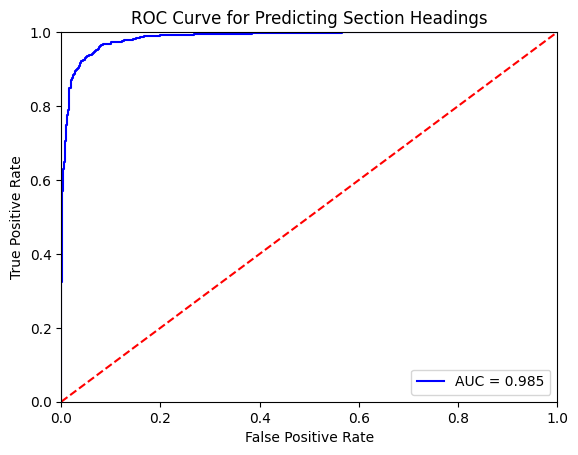

In [5]:
roc_plot(fpr, tpr, roc_auc, title="ROC Curve for Predicting Section Headings")

## Examples of section headings with low scores

In [6]:

test_data = all_df[in_test].copy()

test_data['score'] = scores_test

# section headings with low scores
section_headings_with_low_scores = test_data[test_data['is_heading']==1].sort_values('score', ascending=True).head(n=30)[['text', 'score']]

show_df_as_scrolling_table(section_headings_with_low_scores)


,text,score
1247,"Sodium 2,3,-bis(2-methoxy-4-nitro-5-sulfophenyl)-5-[(phenylamino)-carbonyl]-2 H-tetrazolium inner salt (XTT) assay",0.002470
1686,Sulfasalazine enhances the efficiency of anticancer therapies in CD133-positive HCC but not CD133-negative HCC,0.002758
322,7. Medicines for regular use and medicines used occasionally,0.007502
195,Respiratory chain,0.016898
724,Pharmaceutical drug therapeutic lessons translatable and not translatable to stem cell therapies,0.030733
1575,C57BL/6 wild-type (WT) murine causal prophylactic and treatment dose-ranging studies,0.031826
1683,CD133-positive cells have cancer stem cell-like properties in liver cancer,0.040509
2282,Correlation analysis of OX40 and IL-17 positive tumor immune cell infiltration,0.044127
1468,4.11. Vitreomacular Adhesion and Vitriol Viscosity Inhibitors,0.044659
1134,Availability of essential medicines at public health facilities by therapeutic category,0.046578


## Examples of non-section headings with high scores

In [7]:
non_section_headings_with_high_scores = test_data[test_data['is_heading']==0].sort_values('score', ascending=False).head(n=10)[['text', 'score']]

show_df_as_scrolling_table(non_section_headings_with_high_scores)

,text,score
4226,Matrix Factorization-Based Prediction of Novel Drug Indications by Integrating Genomic Space,0.990160
1953,\n Figure 2Pictographs with the lowest and highest recognition scores\n,0.983423
1727,Environment 5,0.960039
1696,Review of uses of a particular herb 5,0.953305
1583,c. Location of clinical trial,0.931926
6407,"We could obtain module similarities between GO terms of functional modules and function vectors by calculating Jaccard index:\documentclass[12pt]{minimal}\n\t\t\t\t\usepackage{amsmath}\n\t\t\t\t\usepackage{wasysym} \n\t\t\t\t\usepackage{amsfonts} \n\t\t\t\t\usepackage{amssymb} \n\t\t\t\t\usepackage{amsbsy}\n\t\t\t\t\usepackage{mathrsfs}\n\t\t\t\t\usepackage{upgreek}\n\t\t\t\t\setlength{\oddsidemargin}{-69pt}\n\t\t\t\t\begin{document}$$ \begin{array}{l}J\left(FM,\kern0.5em FV\right)\\ {}=\frac{\left|FM\cap \kern0.5em FV\right|}{\left|FM\cup \kern0.5em FV\right|}\\ {}FM:\kern0.5em Function\kern0.5em module,\\ {}FV:\kern0.5em Function\kern0.5em vector\end{array} $$\end{document}J(FM,FV)=|FM∩FV||FM∪FV|FM:Functionmodule,FV:Functionvector",0.912237
1171,To assess the influence of work incapacity in the evolution of the symptoms.,0.907097
10892,Gender Differences in Developing Biomarker-Based Major Depressive Disorder Diagnostics,0.906532
1843,The clinical trial journal article 1,0.893171
1877,None 1,0.883406


# Possible other approaches

## Predicting short passages ending in a colon

We want to be able to find passages that serve as a descriptor for a collection of details to follow, as an alternative way to identify passages that are really metadata for other passages. In many cases, these might be short(ish) sentences or phrases ending with a colon. Can we find enough such examples to train a model.

In [8]:
# has_colon = [ ':' in t for t in selected_articles['text'] ]

# num_colons = [ len(t.split(':')) - 1 for t in selected_articles['text'] ]

# Counter(has_colon)  # False: 9424, True: 2103}
# Counter(num_colons) # {0: 9424, 1: 1571, 2: 283, 3: 93, ...}

# show_df_as_scrolling_table(selected_articles[ [n > 20 for n in num_colons] ][['text']])

# candidates = selected_articles[ [n == 1 for n in num_colons] ][['text']]
# show_df_as_scrolling_table(candidates)

# split into sentences (clauses?). Find sentences with one colon, and more than an abbreviation before it.

# AOPP: Advanced oxidation protein products; BMI: Body mass index; BMRC: British Medical Research Council; CCR: Chemokine (CC motif) receptor; 

# Exclude where section_path == 'Author contributions'

In [ ]:
## Predicting Qustions vs. Answers in FAQs